# **Cálculo del ROP: diferentes escenarios y métodos**

En este Notebook se simulan datos para crear diferentes escenarios para el cálculo del ROP:
- Demanda y tiempos de entrega con distribución normal, $n = 730$.
- Demanda y tiempos de entrega con distribución normal, $n = 10$.
- Demanda con distribución log normal y tiempos de entrega con distribución gamma, $n = 365$.
- Demada con distribución log normal y tiempos de entrega con distribución gamma, $n = 15$.
- Correlación positiva entre demanda y tiempos de entrega.

Para cada escenario se calcula el ROP usando los siguientes métodos:
- ROP determinístico.
- ROP probabilístico que asume normalidad.
- Usando la función de distribución empírica.
- Usando Bootstrap y Monte Carlo.
- Usando Monte Carlo paramétrico.

## Bibliotecas y funciones

In [1]:
# Bibliotecas.
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Funciones.
def simulate_data(n: int = 80, mu_d: float = 500.0, sigma_d: float = 80.0, mu_L: float = 1.2, sigma_L: float = 0.3, seed: int = 42):
    """
    Simula datos de demanda y lead time con distribuciones normales.
    Se recortan valores negativos a un mínimo pequeño positivo.
    Retorna:
    d: np.ndarray
        Vector de demandas simuladas.
    L: np.ndarray
        Vector de lead times simulados.
    """
    rng = np.random.default_rng(seed)

    d = rng.normal(loc=mu_d, scale=sigma_d, size=n)
    L = rng.normal(loc=mu_L, scale=sigma_L, size=n)

    # Asegurar positividad (mínimo > 0)
    d = np.clip(d, a_min=1e-3, a_max=None)
    L = np.clip(L, a_min=1e-3, a_max=None)

    return d, L


def simulate_data2(n: int = 80, mean_log_d: float = 5.5, sigma_log_d: float = 1.1, shape_L: float = 0.4, scale_L: float = 3.0, seed: int = 42):
    """
    Simula demanda y lead time ROMPIENDO claramente el supuesto normal:
    - Demanda ~ Lognormal(mean_log, sigma_log) con cola MUY pesada.
    - Lead time ~ Gamma(shape < 1) con cola derecha larga.
    No se hace ninguna transformación para empatar medias ni varianzas con el
    caso normal: son escenarios "feos" para el modelo probabilístico normal.
    """
    rng = np.random.default_rng(seed)

    # Demanda: lognormal muy asimétrica (valores típicos ~ 200–800, pero con outliers grandes).
    d = rng.lognormal(mean=mean_log_d, sigma=sigma_log_d, size=n)

    # Lead time: gamma muy sesgada (shape < 1) y dispersa.
    L = rng.gamma(shape=shape_L, scale=scale_L, size=n)

    # Asegurar positividad mínima (por seguridad numérica).
    d = np.clip(d, a_min=1e-6, a_max=None)
    L = np.clip(L, a_min=1e-6, a_max=None)

    return d, L


def simulate_data3(n: int = 80, rho: float = 0.7, mean_log_d: float = 5.5, sigma_log_d: float = 1.1,
                   shape_L: float = 0.8, scale_L: float = 2.0, seed: int = 42):
    """
    Simula demanda D y lead time L con CORRELACIÓN POSITIVA:
    1) Genera dos normales correlacionadas (Z1, Z2) con correlación rho.
    2) D = exp(mean_log_d + sigma_log_d * Z1) → lognormal con cola pesada.
    3) L = Gamma(shape, scale * exp(α * Z2)) para inducir correlación positiva.
       Usamos una transformación multiplicativa que mantiene correlación.
    """
    rng = np.random.default_rng(seed)

    # --- 1. Generación de normales correlacionadas ---
    # Matriz de covarianza para Z1, Z2
    cov = np.array([[1.0,     rho],
                    [rho,     1.0]])
    mean = np.array([0.0, 0.0])

    Z = rng.multivariate_normal(mean, cov, size=n)
    Z1, Z2 = Z[:,0], Z[:,1]

    # --- 2. Demanda: Lognormal Z1 ---
    # D = exp(mu + sigma * Z1)
    d = np.exp(mean_log_d + sigma_log_d * Z1)

    # --- 3. Lead time: Gamma correlacionada ---
    # Para inducir correlación positiva fuerte,
    # hacemos que la escala de la gamma dependa de Z2:
    #   scale_eff = scale_L * exp(beta * Z2)
    # con beta > 0 aumenta L cuando Z2 aumenta.
    beta = 0.7  # controla la fuerza de la relación.
    scale_eff = scale_L * np.exp(beta * Z2)

    # L_i = Gamma(shape, scale_eff_i)
    L = rng.gamma(shape=shape_L, scale=scale_eff)

    # Evitar ceros
    d = np.clip(d, a_min=1e-6, a_max=None)
    L = np.clip(L, a_min=1e-6, a_max=None)

    return d, L


def plot_series_and_hist(d: np.ndarray, L: np.ndarray) -> None:
    """
    Grafica series de tiempo e histogramas de demanda y lead time.
    - Serie de tiempo de demanda.
    - Serie de tiempo de lead time.
    - Histograma de demanda.
    - Histograma de lead time.
    """
    t = np.arange(1, len(d) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Serie de tiempo de demanda.
    axes[0, 0].plot(t, d, marker="o")
    axes[0, 0].set_title("Serie de tiempo de la demanda")
    axes[0, 0].set_xlabel("Periodo")
    axes[0, 0].set_ylabel("Demanda")

    # Serie de tiempo de lead time.
    axes[0, 1].plot(t, L, marker="o", color="green")
    axes[0, 1].set_title("Serie de tiempo del lead time")
    axes[0, 1].set_xlabel("Periodo")
    axes[0, 1].set_ylabel("Lead time")

    # Histograma de demanda.
    axes[1, 0].hist(d, bins=12, edgecolor="black")
    axes[1, 0].set_title("Histograma de la demanda")
    axes[1, 0].set_xlabel("Demanda")
    axes[1, 0].set_ylabel("Frecuencia")

    # Histograma de lead time.
    axes[1, 1].hist(L, bins=12, edgecolor="black", color="green")
    axes[1, 1].set_title("Histograma del lead time")
    axes[1, 1].set_xlabel("Lead time")
    axes[1, 1].set_ylabel("Frecuencia")

    plt.tight_layout()
    plt.show()


# Funciones auxiliares para ROP.
def empirical_service_level(rop: float, DL: np.ndarray) -> float:
    """
    Calcula el nivel de servicio empírico dado un ROP y
    una muestra de demanda durante el lead time DL.
    Nivel de servicio = P(DL ≤ ROP) estimado empíricamente.
    """
    return np.mean(DL <= rop)


def rop_deterministic(d: np.ndarray, L: np.ndarray) -> float:
    """
    Método determinístico:
    ROP = E[L] * E[D]
    """
    return float(np.mean(L) * np.mean(d))


def rop_probabilistic_normal(
    d: np.ndarray,
    L: np.ndarray,
    SL_target: float
) -> float:
    """
    Método probabilístico clásico bajo normalidad:
    ROP = E[L] E[D] + z * sqrt( E[L] Var(D) + E[D]^2 Var(L) )
    donde z es el cuantil normal estándar asociado a SL_target.
    """
    mean_d = float(np.mean(d))
    mean_L = float(np.mean(L))
    var_d = float(np.var(d, ddof=1))
    var_L = float(np.var(L, ddof=1))

    var_DL = mean_L * var_d + (mean_d ** 2) * var_L
    sd_DL = np.sqrt(var_DL)

    z = norm.ppf(SL_target)

    rop = mean_L * mean_d + z * sd_DL
    return float(rop)


def rop_ecdf(DL: np.ndarray, SL_target: float) -> float:
    """
    Método empírico (ECDF):
    ROP = cuantil empírico de DL en el nivel SL_target.
    """
    return float(np.quantile(DL, SL_target))


def rop_bootstrap_mc(
    d: np.ndarray,
    L: np.ndarray,
    SL_target: float,
    B: int = 100_000,
    emparejados: bool = False,
    seed: int | None = None
) -> float:
    """
    Método Bootstrap + Monte Carlo.
    Si emparejados = True, se remuestrea por pares (d_i, L_i).
    Si emparejados = False, se remuestrea d y L de manera independiente.
    """
    rng = np.random.default_rng(seed)

    d = np.asarray(d)
    L = np.asarray(L)

    n = len(d)
    m = len(L)

    if emparejados:
        # Se asume n == m
        idx = rng.integers(low=0, high=n, size=B)
        d_star = d[idx]
        L_star = L[idx]
    else:
        d_star = rng.choice(d, size=B, replace=True)
        L_star = rng.choice(L, size=B, replace=True)

    DL_star = d_star * L_star
    return float(np.quantile(DL_star, SL_target))


def rop_parametric_mc(
    mu_d: float,
    sigma_d: float,
    mu_L: float,
    sigma_L: float,
    SL_target: float,
    B: int = 100_000,
    seed: int | None = None
) -> float:
    """
    Método Monte Carlo paramétrico:
    Se asume que conocemos las distribuciones "verdaderas":
    D ~ N(mu_d, sigma_d^2), L ~ N(mu_L, sigma_L^2) (independientes).
    Simulamos B valores de D y L, construimos DL y tomamos el cuantil en SL_target.
    """
    rng = np.random.default_rng(seed)

    d_mc = rng.normal(loc=mu_d, scale=sigma_d, size=B)
    L_mc = rng.normal(loc=mu_L, scale=sigma_L, size=B)

    d_mc = np.clip(d_mc, a_min=1e-3, a_max=None)
    L_mc = np.clip(L_mc, a_min=1e-3, a_max=None)

    DL_mc = d_mc * L_mc
    return float(np.quantile(DL_mc, SL_target))

## Escenario 1: Demanda y tiempos de entrega con distribución normal, n = 730

En este primer escenario suponemos que se tienen datos de la demanda diaria de cierto producto en los últimos dos años (730 días), en un escenario ideal en el que los datos provienen de distribuciones normales, como se observa en los histogramas más abajo.

In [2]:
# Parámetros.
n = 730
mu_d = 500.0
sigma_d = 80.0
mu_L = 1.2
sigma_L = 0.3
SL_target = 0.90
B = 100_000

# Simulación.
d, L = simulate_data(n=n, mu_d=mu_d, sigma_d=sigma_d, mu_L=mu_L, sigma_L=sigma_L, seed=42)

print(f"Demanda: {np.round(d[0:9])}")
print(f"\nTiempo de entrega: {np.round(L[0:9], 2)}")

Demanda: [524. 417. 560. 575. 344. 396. 510. 475. 499.]

Tiempo de entrega: [1.33 1.22 1.36 1.14 1.28 1.25 1.43 1.44 0.71]


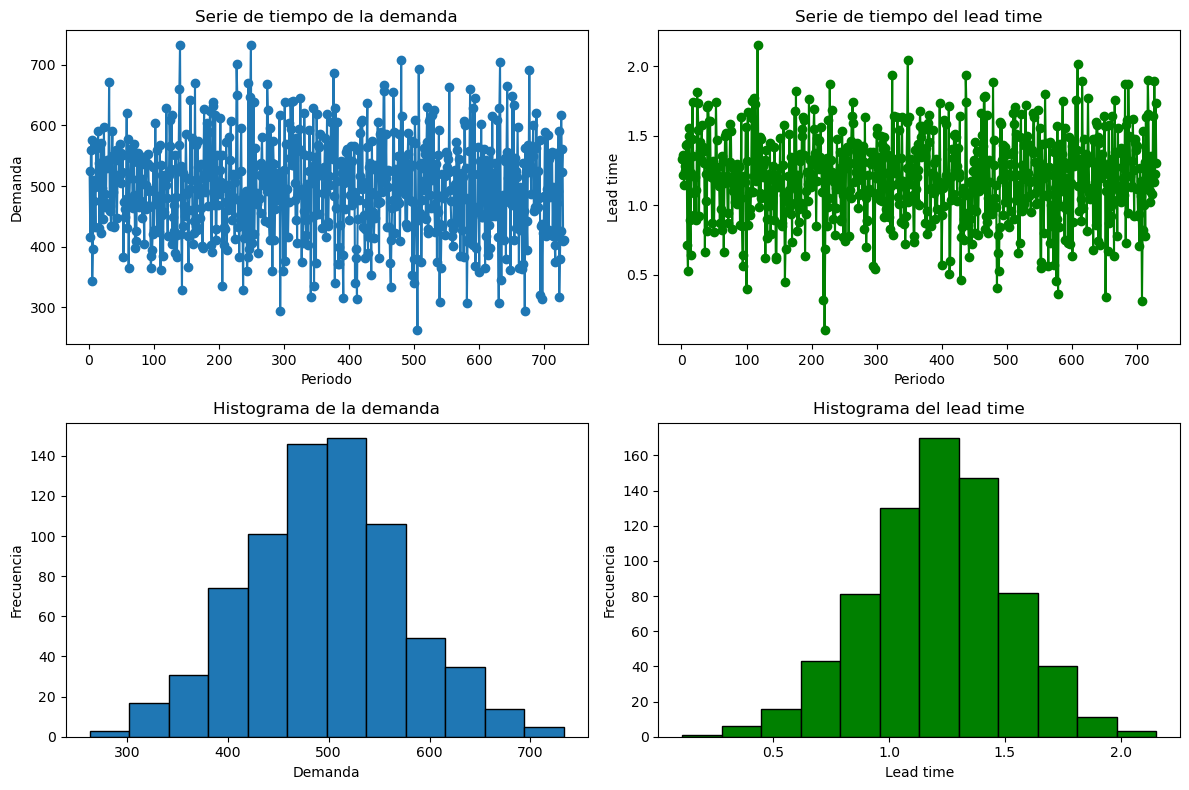

In [42]:
# Gráficas.
plot_series_and_hist(d, L)

In [44]:
# Demanda durante el lead time (histórica).
DL_hist = d * L

# Método 1: determinístico.
rop_det = rop_deterministic(d, L)
SL_det = empirical_service_level(rop_det, DL_hist)

# Método 2: probabilístico normal clásico.
rop_norm = rop_probabilistic_normal(d, L, SL_target=SL_target)
SL_norm = empirical_service_level(rop_norm, DL_hist)

# Método 3: ECDF (empírico).
rop_ecdf_val = rop_ecdf(DL_hist, SL_target=SL_target)
SL_ecdf = empirical_service_level(rop_ecdf_val, DL_hist)

# Método 4: Bootstrap + Monte Carlo.
rop_boot = rop_bootstrap_mc(d, L, SL_target=SL_target, B=B, emparejados=False, seed=123)
SL_boot = empirical_service_level(rop_boot, DL_hist)

# Método 5: Monte Carlo paramétrico.
rop_param = rop_parametric_mc(mu_d=mu_d, sigma_d=sigma_d, mu_L=mu_L, sigma_L=sigma_L, SL_target=SL_target, B=B, seed=999)
SL_param = empirical_service_level(rop_param, DL_hist)

# Resultados en consola.
print("===============================================")
print("Resultados de ROP y nivel de servicio empírico")
print("Datos simulados: n =", n)
print("SL objetivo:", SL_target)
print("===============================================")
print(f"1) Determinístico:")
print(f"   ROP = {rop_det:.2f}")
print(f"   SL empírico ≈ {SL_det:.4f}")
print("-----------------------------------------------")
print(f"2) Probabilístico normal:")
print(f"   ROP = {rop_norm:.2f}")
print(f"   SL empírico ≈ {SL_norm:.4f}")
print("-----------------------------------------------")
print(f"3) ECDF (empírico):")
print(f"   ROP = {rop_ecdf_val:.2f}")
print(f"   SL empírico ≈ {SL_ecdf:.4f}")
print("-----------------------------------------------")
print(f"4) Bootstrap + Monte Carlo:")
print(f"   ROP = {rop_boot:.2f}")
print(f"   SL empírico ≈ {SL_boot:.4f}")
print("-----------------------------------------------")
print(f"5) Monte Carlo paramétrico:")
print(f"   ROP = {rop_param:.2f}")
print(f"   SL empírico ≈ {SL_param:.4f}")
print("===============================================")

Resultados de ROP y nivel de servicio empírico
Datos simulados: n = 730
SL objetivo: 0.9
1) Determinístico:
   ROP = 597.84
   SL empírico ≈ 0.4904
-----------------------------------------------
2) Probabilístico normal:
   ROP = 821.12
   SL empírico ≈ 0.8863
-----------------------------------------------
3) ECDF (empírico):
   ROP = 837.37
   SL empírico ≈ 0.9000
-----------------------------------------------
4) Bootstrap + Monte Carlo:
   ROP = 830.53
   SL empírico ≈ 0.8932
-----------------------------------------------
5) Monte Carlo paramétrico:
   ROP = 835.79
   SL empírico ≈ 0.8986


**Comentarios:**

- El ROP determinístico es mucho más bajo que los demás, pero el nivel de servicio también es mucho más bajo.
- El nivel de servicio del 0.4904 se interpreta así: el 49.04 % de las veces, el inventario durante el tiempo de entrega será suficiente para satisfacer la demanda durante el tiempo de entrega, por lo que no habrá ruptura de stock.
- Observe que un nivel de servicio mayor requiere también un ROP mayor, porque conlleva un mayor inventario de seguridad.
- El modelo probabilístico es totalmente válido en este escenario puesto que se cumplen los supuestos requeridos. Observe que, de hecho, sus resultados son muy parecidos a los métodos no paramétricos.

## Escenario 2: Demanda y tiempos de entrega con distribución normal, n = 10

Supongamos ahora un escenario en el que la demanda es mensual y se tiene apenas información de los últimos 10 meses. Demanda y tiempos de entrega siguen teniendo distribución normal, aunque la verificación del supuesto se vuelve más complicada porque son pocos datos, como muestran los histogramas de abajo.

In [46]:
# Parámetros.
n = 10
mu_d = 500.0
sigma_d = 80.0
mu_L = 1.2
sigma_L = 0.3
SL_target = 0.90
B = 100_000

# Simulación.
d, L = simulate_data(n=n, mu_d=mu_d, sigma_d=sigma_d, mu_L=mu_L, sigma_L=sigma_L, seed=42)

print(f"Demanda: {np.round(d[0:9])}")
print(f"\nTiempo de entrega: {np.round(L[0:9], 2)}")

Demanda: [524. 417. 560. 575. 344. 396. 510. 475. 499.]

Tiempo de entrega: [1.46 1.43 1.22 1.54 1.34 0.94 1.31 0.91 1.46]


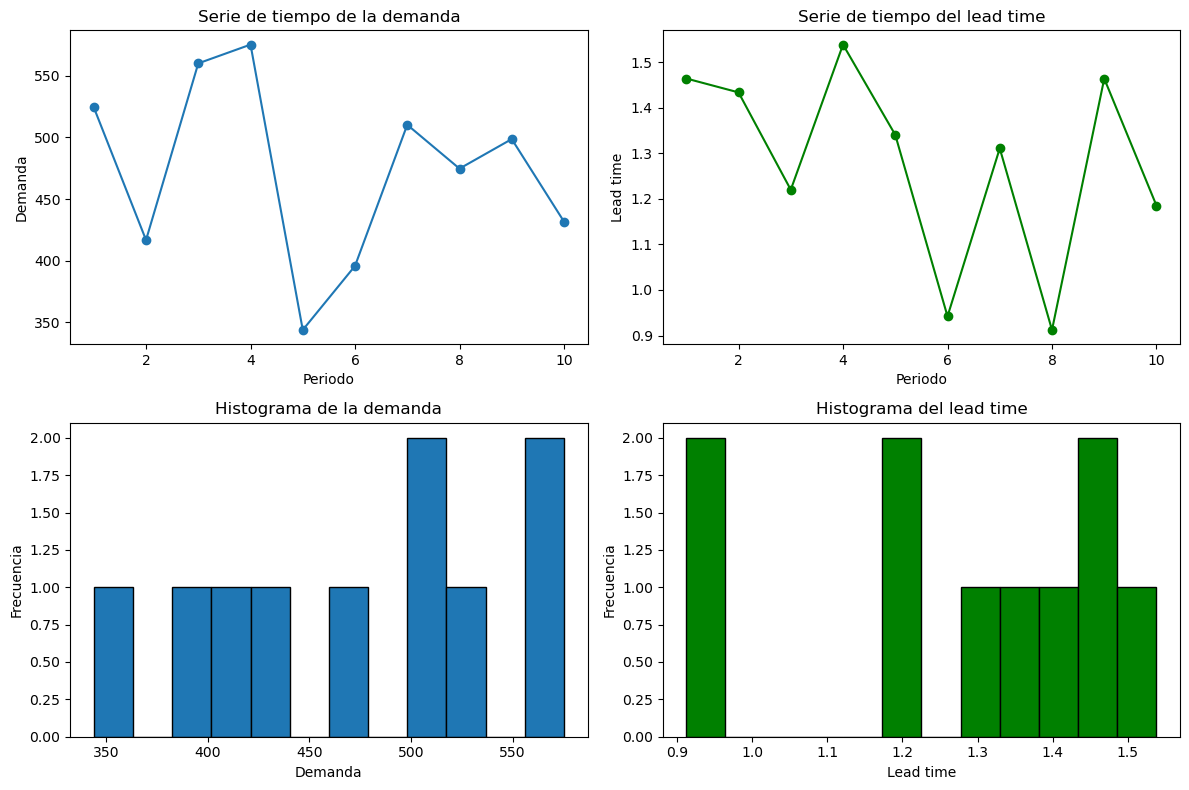

In [47]:
# Gráficas.
plot_series_and_hist(d, L)

In [48]:
# Demanda durante el lead time (histórica).
DL_hist = d * L

# Método 1: determinístico.
rop_det = rop_deterministic(d, L)
SL_det = empirical_service_level(rop_det, DL_hist)

# Método 2: probabilístico normal clásico.
rop_norm = rop_probabilistic_normal(d, L, SL_target=SL_target)
SL_norm = empirical_service_level(rop_norm, DL_hist)

# Método 3: ECDF (empírico).
rop_ecdf_val = rop_ecdf(DL_hist, SL_target=SL_target)
SL_ecdf = empirical_service_level(rop_ecdf_val, DL_hist)

# Método 4: Bootstrap + Monte Carlo.
rop_boot = rop_bootstrap_mc(d, L, SL_target=SL_target, B=B, emparejados=False, seed=123)
SL_boot = empirical_service_level(rop_boot, DL_hist)

# Método 5: Monte Carlo paramétrico.
rop_param = rop_parametric_mc(mu_d=mu_d, sigma_d=sigma_d, mu_L=mu_L, sigma_L=sigma_L, SL_target=SL_target, B=B, seed=999)
SL_param = empirical_service_level(rop_param, DL_hist)

# Resultados en consola.
print("===============================================")
print("Resultados de ROP y nivel de servicio empírico")
print("Datos simulados: n =", n)
print("SL objetivo:", SL_target)
print("===============================================")
print(f"1) Determinístico:")
print(f"   ROP = {rop_det:.2f}")
print(f"   SL empírico ≈ {SL_det:.4f}")
print("-----------------------------------------------")
print(f"2) Probabilístico normal:")
print(f"   ROP = {rop_norm:.2f}")
print(f"   SL empírico ≈ {SL_norm:.4f}")
print("-----------------------------------------------")
print(f"3) ECDF (empírico):")
print(f"   ROP = {rop_ecdf_val:.2f}")
print(f"   SL empírico ≈ {SL_ecdf:.4f}")
print("-----------------------------------------------")
print(f"4) Bootstrap + Monte Carlo:")
print(f"   ROP = {rop_boot:.2f}")
print(f"   SL empírico ≈ {SL_boot:.4f}")
print("-----------------------------------------------")
print(f"5) Monte Carlo paramétrico:")
print(f"   ROP = {rop_param:.2f}")
print(f"   SL empírico ≈ {SL_param:.4f}")
print("===============================================")

Resultados de ROP y nivel de servicio empírico
Datos simulados: n = 10
SL objetivo: 0.9
1) Determinístico:
   ROP = 606.07
   SL empírico ≈ 0.5000
-----------------------------------------------
2) Probabilístico normal:
   ROP = 776.54
   SL empírico ≈ 0.9000
-----------------------------------------------
3) ECDF (empírico):
   ROP = 779.32
   SL empírico ≈ 0.9000
-----------------------------------------------
4) Bootstrap + Monte Carlo:
   ROP = 770.97
   SL empírico ≈ 0.9000
-----------------------------------------------
5) Monte Carlo paramétrico:
   ROP = 835.79
   SL empírico ≈ 0.9000


**Comentarios:**

  - Con n = 10, el cuantil empírico 0.90 es prácticamente el 9-ésimo orden estadístico, así que es normal que el SL caiga exactamente en 0.9 al evaluar con la misma muestra.
  - El ROP determinístico, como en el escenario anterior, está muy por debajo del de los otros métodos, pero también su nivel de servicio.
  - En esta simulación en particular, la varianza muestral resultó menor que en el caso n = 730 (algo frecuente con muestras pequeñas), lo que se traduce en un inventario de seguridad más pequeño y, por lo tanto, en un ROP menor.

## Escenario 3: Demanda lognormal y tiempos de entrega gamma, n = 365

In [12]:
# Parámetros.
n = 365
mean_log_d = 5.5
sigma_log_d = 1.1
shape_L = 0.4
scale_L = 3.0
SL_target = 0.90
B = 100_000

# Simulación.
d, L = simulate_data2(n = n, mean_log_d = mean_log_d, sigma_log_d = sigma_log_d, shape_L = shape_L, scale_L = 3.0)

print(f"Demanda: {np.round(d[0:9])}")
print(f"\nTiempo de entrega: {np.round(L[0:9], 2)}")

Demanda: [342.  78. 559. 689.  29.  58. 282. 173. 240.]

Tiempo de entrega: [1.49 6.17 0.48 2.95 0.02 0.42 0.14 5.1  0.01]


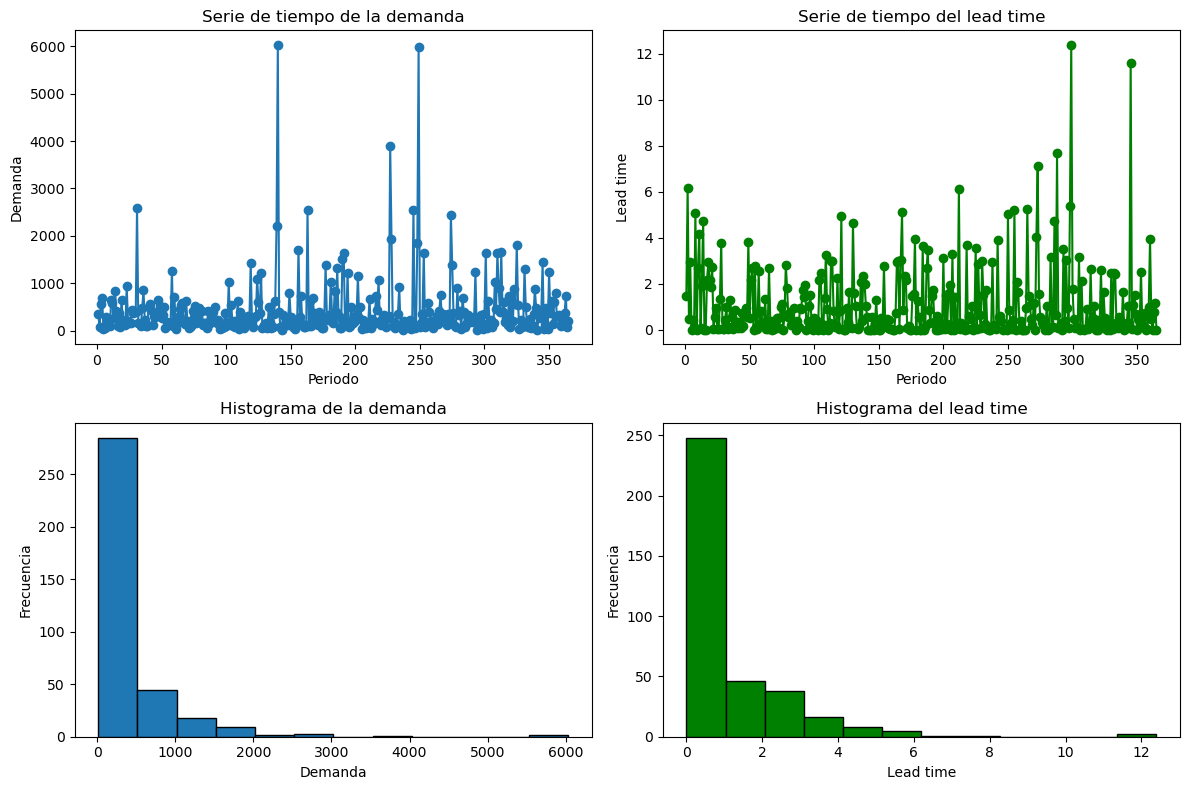

In [13]:
# Gráficas.
plot_series_and_hist(d, L)

In [14]:

# Demanda durante el lead time (histórica).
DL_hist = d * L

# Método 1: determinístico.
rop_det = rop_deterministic(d, L)
SL_det = empirical_service_level(rop_det, DL_hist)

# Método 2: probabilístico normal clásico.
rop_norm = rop_probabilistic_normal(d, L, SL_target=SL_target)
SL_norm = empirical_service_level(rop_norm, DL_hist)

# Método 3: ECDF (empírico).
rop_ecdf_val = rop_ecdf(DL_hist, SL_target=SL_target)
SL_ecdf = empirical_service_level(rop_ecdf_val, DL_hist)

# Método 4: Bootstrap + Monte Carlo.
rop_boot = rop_bootstrap_mc(
    d, L,
    SL_target=SL_target,
    B=B,
    emparejados=False,
    seed=123
)
SL_boot = empirical_service_level(rop_boot, DL_hist)

# Método 5: Monte Carlo paramétrico (mal especificado como normal).
# Estimamos media y sd MUESTRALES, pero asumimos normalidad (que NO se cumple).
mu_d_hat = float(np.mean(d))
sigma_d_hat = float(np.std(d, ddof=1))
mu_L_hat = float(np.mean(L))
sigma_L_hat = float(np.std(L, ddof=1))

rop_param = rop_parametric_mc(
    mu_d=mu_d_hat,
    sigma_d=sigma_d_hat,
    mu_L=mu_L_hat,
    sigma_L=sigma_L_hat,
    SL_target=SL_target,
    B=B,
    seed=999
)
SL_param = empirical_service_level(rop_param, DL_hist)

# Resultados en consola.
print("===============================================")
print("Resultados de ROP y nivel de servicio empírico")
print("Datos simulados: n =", n)
print("SL objetivo:", SL_target)
print("===============================================")
print(f"1) Determinístico:")
print(f"   ROP = {rop_det:.2f}")
print(f"   SL empírico ≈ {SL_det:.4f}")
print("-----------------------------------------------")
print(f"2) Probabilístico normal:")
print(f"   ROP = {rop_norm:.2f}")
print(f"   SL empírico ≈ {SL_norm:.4f}")
print("-----------------------------------------------")
print(f"3) ECDF (empírico):")
print(f"   ROP = {rop_ecdf_val:.2f}")
print(f"   SL empírico ≈ {SL_ecdf:.4f}")
print("-----------------------------------------------")
print(f"4) Bootstrap + Monte Carlo:")
print(f"   ROP = {rop_boot:.2f}")
print(f"   SL empírico ≈ {SL_boot:.4f}")
print("-----------------------------------------------")
print(f"5) Monte Carlo paramétrico (normal mal especificado):")
print(f"   ROP = {rop_param:.2f}")
print(f"   SL empírico ≈ {SL_param:.4f}")
print("===============================================")

Resultados de ROP y nivel de servicio empírico
Datos simulados: n = 365
SL objetivo: 0.9
1) Determinístico:
   ROP = 458.61
   SL empírico ≈ 0.7616
-----------------------------------------------
2) Probabilístico normal:
   ROP = 1668.01
   SL empírico ≈ 0.9342
-----------------------------------------------
3) ECDF (empírico):
   ROP = 1099.54
   SL empírico ≈ 0.8986
-----------------------------------------------
4) Bootstrap + Monte Carlo:
   ROP = 1084.19
   SL empírico ≈ 0.8959
-----------------------------------------------
5) Monte Carlo paramétrico (normal mal especificado):
   ROP = 2141.23
   SL empírico ≈ 0.9616


**Comentarios:**

- Como los datos ya no provienen de distribuciones simétricas (normales) sino asimétricas (lognormal y gamma, ambas con colas derechas pesadas), el nivel de servicio en el modelo determinístico es mayor que el 50 %, donde qué tan mayor depende del nivel de asimetría de las distribuciones; esto ya que el ROP es la media en este caso, pero la media está por arriba de la mediana, que representa el cuantil 0.50 de la distribución.
- El modelo probabilístico normal sobreestima el ROP (1668) y deja un SL superior al objetivo (93.4 %). Esto ocurre porque la aproximación normal al cuantil de DL no es adecuada cuando la distribución de DL (producto de una lognormal con una gamma) es fuertemente asimétrica y con colas pesadas; la fórmula basada solo en media y varianza exagera el inventario de seguridad.
- El Monte Carlo paramétrico está mal especificado (sigue asumiendo D y L normales), por eso su ROP = 2141 y su SL = 96 % sobreestima la cola en comparación con ECDF/Bootstrap.
- ECDF y Bootstrap resultan ser los que presentan el ROP que se aproxima mejor al nivel de servicio deseado.

## Escenario 4: Demanda lognormal y tiempos de entrega gamma, n = 15

In [17]:
# Parámetros.
n = 15
mean_log_d = 5.5
sigma_log_d = 1.1
shape_L = 0.4
scale_L = 3.0
SL_target = 0.90
B = 100_000

# Simulación.
d, L = simulate_data2(n = n, mean_log_d = mean_log_d, sigma_log_d = sigma_log_d, shape_L = shape_L, scale_L = 3.0)

print(f"Demanda: {np.round(d[0:9])}")
print(f"\nTiempo de entrega: {np.round(L[0:9], 2)}")

Demanda: [342.  78. 559. 689.  29.  58. 282. 173. 240.]

Tiempo de entrega: [0.07 0.   0.96 0.22 4.05 0.05 0.   1.2  0.25]


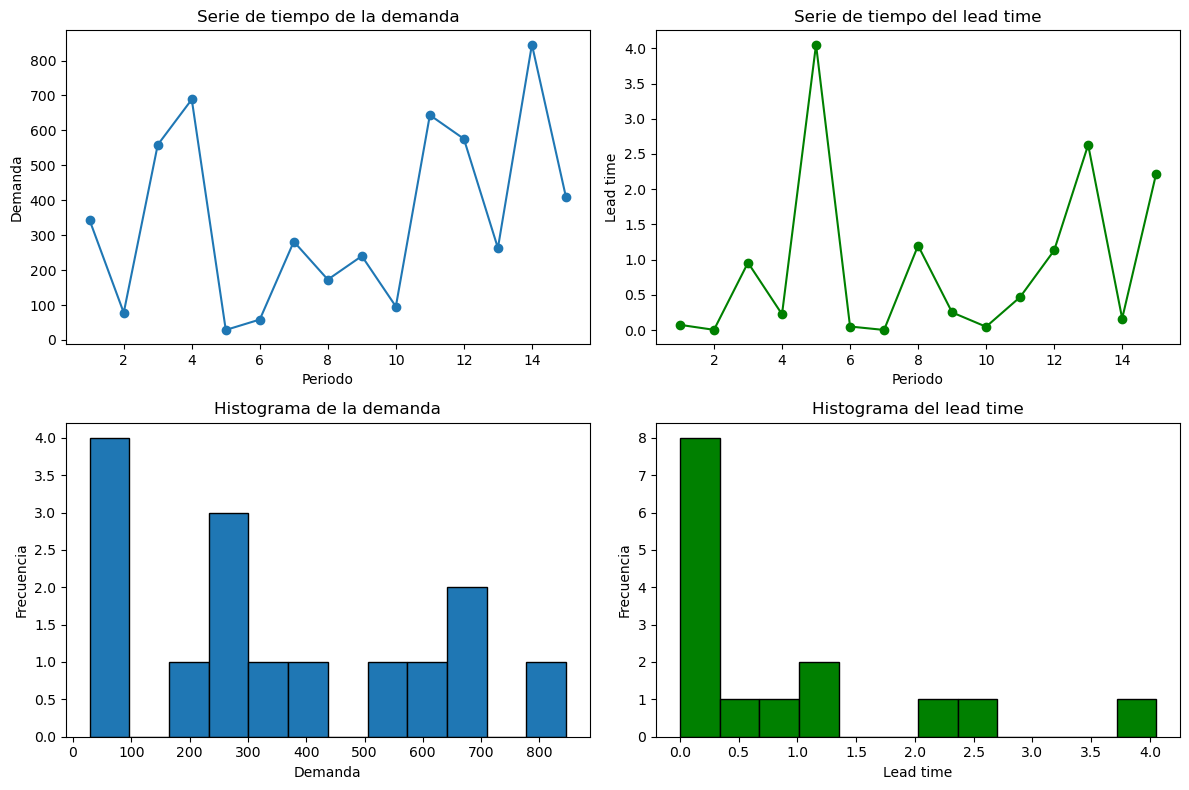

In [18]:
# Gráficas.
plot_series_and_hist(d, L)

In [19]:
# Demanda durante el lead time (histórica).
DL_hist = d * L

# Método 1: determinístico.
rop_det = rop_deterministic(d, L)
SL_det = empirical_service_level(rop_det, DL_hist)

# Método 2: probabilístico normal clásico (suponiendo normalidad en D y L).
rop_norm = rop_probabilistic_normal(d, L, SL_target=SL_target)
SL_norm = empirical_service_level(rop_norm, DL_hist)

# Método 3: ECDF (empírico).
rop_ecdf_val = rop_ecdf(DL_hist, SL_target=SL_target)
SL_ecdf = empirical_service_level(rop_ecdf_val, DL_hist)

# Método 4: Bootstrap + Monte Carlo.
rop_boot = rop_bootstrap_mc(
    d, L,
    SL_target=SL_target,
    B=B,
    emparejados=False,
    seed=123
)
SL_boot = empirical_service_level(rop_boot, DL_hist)

# Método 5: Monte Carlo paramétrico (normal mal especificado: usa momentos muestrales).
mu_d_hat = float(np.mean(d))
sigma_d_hat = float(np.std(d, ddof=1))
mu_L_hat = float(np.mean(L))
sigma_L_hat = float(np.std(L, ddof=1))

rop_param = rop_parametric_mc(
    mu_d=mu_d_hat,
    sigma_d=sigma_d_hat,
    mu_L=mu_L_hat,
    sigma_L=sigma_L_hat,
    SL_target=SL_target,
    B=B,
    seed=999
)
SL_param = empirical_service_level(rop_param, DL_hist)

# Resultados en consola.
print("===============================================")
print("Resultados de ROP y nivel de servicio empírico")
print("Datos simulados: n =", n)
print("SL objetivo:", SL_target)
print("===============================================")
print(f"1) Determinístico:")
print(f"   ROP = {rop_det:.2f}")
print(f"   SL empírico ≈ {SL_det:.4f}")
print("-----------------------------------------------")
print(f"2) Probabilístico normal:")
print(f"   ROP = {rop_norm:.2f}")
print(f"   SL empírico ≈ {SL_norm:.4f}")
print("-----------------------------------------------")
print(f"3) ECDF (empírico):")
print(f"   ROP = {rop_ecdf_val:.2f}")
print(f"   SL empírico ≈ {SL_ecdf:.4f}")
print("-----------------------------------------------")
print(f"4) Bootstrap + Monte Carlo:")
print(f"   ROP = {rop_boot:.2f}")
print(f"   SL empírico ≈ {SL_boot:.4f}")
print("-----------------------------------------------")
print(f"5) Monte Carlo paramétrico (normal, mal especificado):")
print(f"   ROP = {rop_param:.2f}")
print(f"   SL empírico ≈ {SL_param:.4f}")
print("===============================================")


Resultados de ROP y nivel de servicio empírico
Datos simulados: n = 15
SL objetivo: 0.9
1) Determinístico:
   ROP = 316.30
   SL empírico ≈ 0.7333
-----------------------------------------------
2) Probabilístico normal:
   ROP = 941.79
   SL empírico ≈ 1.0000
-----------------------------------------------
3) ECDF (empírico):
   ROP = 675.37
   SL empírico ≈ 0.8667
-----------------------------------------------
4) Bootstrap + Monte Carlo:
   ROP = 955.61
   SL empírico ≈ 1.0000
-----------------------------------------------
5) Monte Carlo paramétrico (normal, mal especificado):
   ROP = 1052.98
   SL empírico ≈ 1.0000


**Comentarios:**

- Nuevamente el ROP determinístico ofrece un nivel de servicio muy por arriba del 50 %, debido a la asimetría de la distribución.
- Con n = 15 y colas pesadas, el método Bootstrap tiende a ser muy conservador: al remuestrear con reemplazo, los valores extremos pueden aparecer muchas veces, inflando la cola derecha de DL* y elevando el ROP hasta lograr niveles de servicio cercanos al 100 %.
- Observe cómo tanto en este escenario como en el anterior, aumentos ligeros en el nivel de servicio provocan aumentos enormes en el ROP; esto también conduce a mayores gastos de mantenimiento de inventario. Por ejemplo, un ROP de 675 proporciona un nivel de servicio de 73 %, mientras que un ROP de 835 proporciona un ROP de 86 %.
- ECDF queda casi igual de cerca del objetivo (0.8667 y 0.9333), mientras que el normal y Monte Carlo se van a SL = 1.0, dando ejemplos de sobreprotección.

## Escenario 5: Correlación positiva entre demanda y tiempos de entrega

In [23]:
# Parámetros.
n = 200
rho = 0.7
mean_log_d = 5.5
sigma_log_d = 1.1
shape_L = 0.3
scale_L = 2.0
SL_target = 0.90
B = 100_000

# Simulación.
d, L = simulate_data3(rho = rho, mean_log_d = mean_log_d, sigma_log_d = sigma_log_d, shape_L = shape_L, scale_L = scale_L)

print(f"Demanda: {np.round(d[0:9])}")
print(f"\nTiempo de entrega: {np.round(L[0:9], 2)}")

Demanda: [ 280.   77. 3082.  246.  358.   72.  142.  220.  253.]

Tiempo de entrega: [0.   0.06 2.71 3.61 0.18 2.32 0.   0.46 1.26]


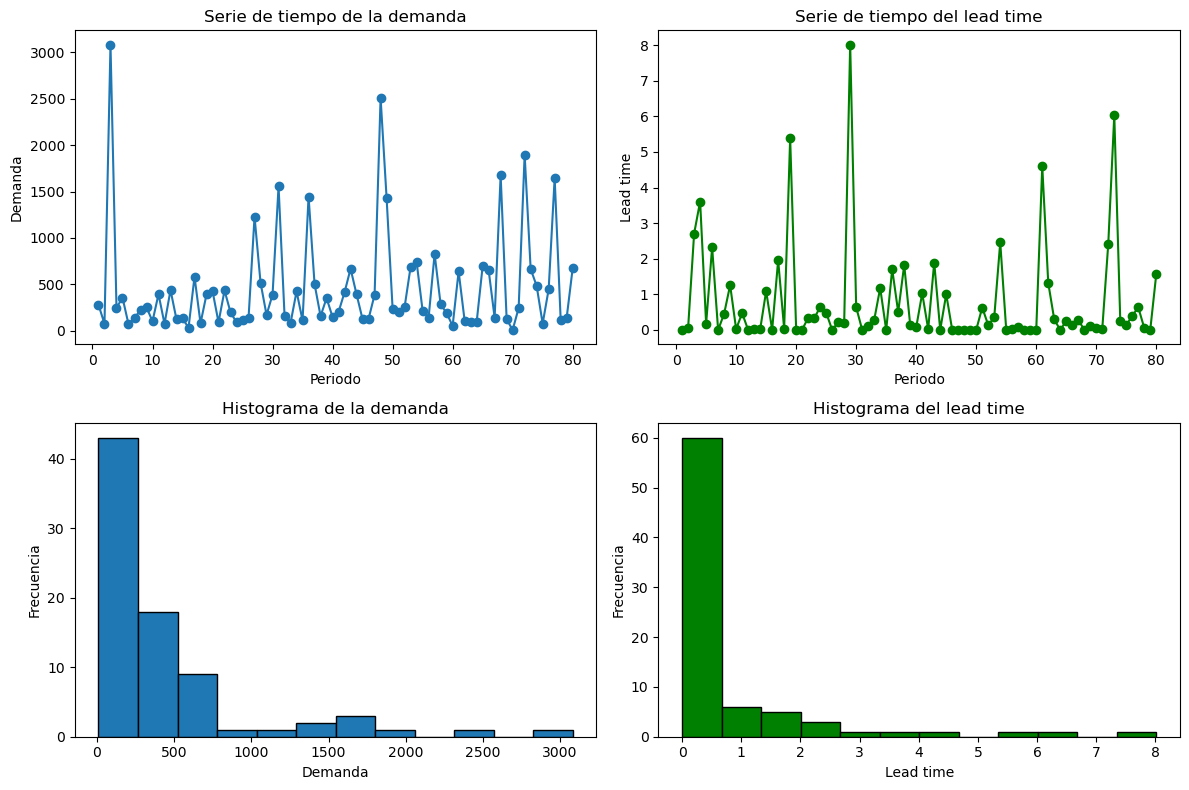

In [24]:
# Gráficas.
plot_series_and_hist(d, L)

In [25]:
# Demanda durante el lead time (histórica).
DL_hist = d * L

# Método 1: determinístico.
rop_det = rop_deterministic(d, L)
SL_det = empirical_service_level(rop_det, DL_hist)

# Método 2: probabilístico normal clásico (mal especificado a propósito).
rop_norm = rop_probabilistic_normal(d, L, SL_target=SL_target)
SL_norm = empirical_service_level(rop_norm, DL_hist)

# Método 3: ECDF (empírico).
rop_ecdf_val = rop_ecdf(DL_hist, SL_target=SL_target)
SL_ecdf = empirical_service_level(rop_ecdf_val, DL_hist)

# Método 4: Bootstrap + Monte Carlo (respetando la correlación D–L).
rop_boot = rop_bootstrap_mc(d, L, SL_target=SL_target, B=B,
                            emparejados=True, seed=123)
SL_boot = empirical_service_level(rop_boot, DL_hist)

# Método 5: Monte Carlo paramétrico NORMAL
# (usa medias y desviaciones muestrales, asumiendo D y L ~ normales independientes).
mu_d_hat     = float(np.mean(d))
sigma_d_hat  = float(np.std(d, ddof=1))
mu_L_hat     = float(np.mean(L))
sigma_L_hat  = float(np.std(L, ddof=1))

rop_param = rop_parametric_mc(mu_d=mu_d_hat, sigma_d=sigma_d_hat,
                              mu_L=mu_L_hat, sigma_L=sigma_L_hat,
                              SL_target=SL_target, B=B, seed=999)
SL_param = empirical_service_level(rop_param, DL_hist)

# Resultados en consola.
print("===============================================")
print("Resultados de ROP y nivel de servicio empírico")
print("Datos simulados: n =", n)
print("SL objetivo:", SL_target)
print("===============================================")
print(f"1) Determinístico:")
print(f"   ROP = {rop_det:.2f}")
print(f"   SL empírico ≈ {SL_det:.4f}")
print("-----------------------------------------------")
print(f"2) Probabilístico normal:")
print(f"   ROP = {rop_norm:.2f}")
print(f"   SL empírico ≈ {SL_norm:.4f}")
print("-----------------------------------------------")
print(f"3) ECDF (empírico):")
print(f"   ROP = {rop_ecdf_val:.2f}")
print(f"   SL empírico ≈ {SL_ecdf:.4f}")
print("-----------------------------------------------")
print(f"4) Bootstrap + Monte Carlo (emparejado):")
print(f"   ROP = {rop_boot:.2f}")
print(f"   SL empírico ≈ {SL_boot:.4f}")
print("-----------------------------------------------")
print(f"5) Monte Carlo paramétrico (normal):")
print(f"   ROP = {rop_param:.2f}")
print(f"   SL empírico ≈ {SL_param:.4f}")
print("===============================================")


Resultados de ROP y nivel de servicio empírico
Datos simulados: n = 200
SL objetivo: 0.9
1) Determinístico:
   ROP = 357.51
   SL empírico ≈ 0.8250
-----------------------------------------------
2) Probabilístico normal:
   ROP = 1422.22
   SL empírico ≈ 0.9125
-----------------------------------------------
3) ECDF (empírico):
   ROP = 1275.91
   SL empírico ≈ 0.9000
-----------------------------------------------
4) Bootstrap + Monte Carlo (emparejado):
   ROP = 1371.39
   SL empírico ≈ 0.9125
-----------------------------------------------
5) Monte Carlo paramétrico (normal):
   ROP = 1735.04
   SL empírico ≈ 0.9125


**Comentarios:**

- El ROP probabilístico normal sigue dejando un nivel de servicio por arriba de lo deseado, aunque un poco más cerca. La fórmula del ROP probabilística puede ajustarse para que considere correlación entre demanda y tiempos de entrega, pero aún sigue asumiendo distribuciones normales para ambos.
- Los métodos con Monte Carlo están dejando un nivel de servicio por ligeramentr por arriba del nivel de servicio deseado, mientras que el empírico por construcción mantiene el nivel de servicio deseado.

**Comentarios generales:**

- En casi todos los escenarios, el método empírico es el que ofrece niveles de servicio más cercanos al 90 % o se encuentra entre los mejores.
- Con n pequeño y colas pesadas, Bootstrap puede ser muy conservador, lo cual puede ser deseable (si priorizas evitar faltantes) pero costoso (mucho inventario de seguridad).
- ECDF es especialmente atractivo porque ataca directamente el cuantil de DL, sin pasar por supuestos de normalidad ni fórmulas cerradas.
- El método determinístico sistemáticamente subestima el ROP necesario cuando se busca un SL alto. Con distribuciones simétricas, su SL se queda alrededor del 50 %. Con colas derechas, el SL sube por encima del 50 %, pero sigue lejos de niveles de servicio como 90 %.
- El modelo probabilístico normal funciona bien cuando: D y L son aproximadamente normales, independientes, y el tamaño de muestra es moderado/grande. En cuanto hay colas pesadas o correlación positiva, puede dar ROPs exageradamente altos (escenarios 3, 4, 5).
- Monte Carlo paramétrico actúa como “oráculo” solo cuando el modelo es correcto (escenarios 1 y 2). En escenarios 3 y 4 hereda los sesgos del modelo mal especificado (normal e independencia), subestimando o sobreestimando dependiendo del caso.
- Bootstrap con MC es muy potente, pero con muestras pequeñas y colas pesadas, tiende a ser conservador; con correlación, debe remuestrear por pares (emparejados=True) para no romper la estructura de dependencia.